# Setup

In [1]:
pip install -r ../../requirements.txt

Looking in indexes: https://pypi.org/simple/, https://****@pkgs.dev.azure.com/parsionate-ai/ps-libraries/_packaging/pypi-feed/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
# Add directory above current directory to path
import sys; sys.path.insert(0, '../..')

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [5]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

2023-05-28 13:21:25.376123: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 13:21:26.046692: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-05-28 13:21:26.046765: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 27236 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:25:00.0, compute capability: 7.0


In [6]:
config = json.load(open("./configs/mnn_em.json"))

# Loading data

In [7]:
from data_loader.abo import ABO

In [8]:
data = ABO(
    path=config["data"]["path"],
    download=True,
    extract=False,
    preprocess=True,
    alt_augment=False,
    random_deletion=True,
    export_csv=True).data

# data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
# data = data.drop({"Unnamed: 0"}, axis=1)

data = data[['description', 'path', 'product_type', 'label']]
data

abo-listings.tar already exists.
abo-images-small.tar already exists.
Loading images...
Loading texts...
Importing listings CSV...
Creating false samples/complement...
Merging ground truth and complement...
Performing random deletion...
Concatenating attributes into description columns...
Finishing up...
Exporting to CSV...
Data processing complete


,description,path,product_type,label
0,"365 everyday value reduced fat milk, 16 oz",8a/8a8d3c0c.jpg,GROCERY,1
1,b08569tzf4,b3/b3d38943.jpg,HEADBOARD,0
2,"find. women's 43510 boots, black black 01, 8 us",e3/e3a0e881.jpg,CELLULAR_PHONE_CASE,0
3,amazon brand - solimo designer lake view uv pr...,e7/e7d8c484.jpg,CELLULAR_PHONE_CASE,1
4,b079qclq1yamazon brand - solimo designer stone...,57/57e8f627.jpg,GROCERY,0
...,...,...,...,...
141816,b07tc5wzqzamazon brand - solimo designer water...,d3/d3960a36.jpg,CELLULAR_PHONE_CASE,0
141817,mobile coverb0856b24vlamazon brand - solimo de...,e1/e1d850a9.jpg,SHOES,0
141818,amazon brand - solimo designer queen 3d printe...,2d/2da26748.jpg,CELLULAR_PHONE_CASE,0
141819,b07t9tkrphamazon brand - solimo designer golde...,69/69181e4f.jpg,CELLULAR_PHONE_CASE,0


In [9]:
img = data[["path"]] # two brackets for keeping the column name
text = data["description"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Text processing

## Tokenize texts

In [10]:
tk = CharTokenizer(config["data"]["alphabet"])
text = tk.tokenize(text)
text.shape

(141821, 1014)

## Create embedding weights

In [11]:
weights = tk.create_embedding_weights()
weights.shape

(64, 63)

# Image processing

## Load image model

In [12]:
from utils.img_processing import load_img_model, create_embeddings_from

In [13]:
img_model = load_img_model(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [14]:
# Mobilenetv3small:
# batch_size = 1024 -> 8 GB VRAM
# batch_size = 2048 -> 16 GB VRAM
# ...
# Mobilenetv3large: twice as much as Mobilenetv3small

img = create_embeddings_from(img_model, img, os.path.join(config["data"]["path"], "images/small"), batch_size=1024)

In [15]:
img.shape

(141714, 1)

# Save embeddings

In [14]:
save_path = os.path.join(config["data"]["path"], f"embeddings/{img_model.name}")

In [15]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/text.npy", text)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [16]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,path,product_type,label
0,"365 everyday value reduced fat milk, 16 oz",8a/8a8d3c0c.jpg,GROCERY,1
1,b08569tzf4,b3/b3d38943.jpg,HEADBOARD,0
2,"find. women's 43510 boots, black black 01, 8 us",e3/e3a0e881.jpg,CELLULAR_PHONE_CASE,0
3,amazon brand - solimo designer lake view uv pr...,e7/e7d8c484.jpg,CELLULAR_PHONE_CASE,1
4,b079qclq1yamazon brand - solimo designer stone...,57/57e8f627.jpg,GROCERY,0
...,...,...,...,...
141816,b07tc5wzqzamazon brand - solimo designer water...,d3/d3960a36.jpg,CELLULAR_PHONE_CASE,0
141817,mobile coverb0856b24vlamazon brand - solimo de...,e1/e1d850a9.jpg,SHOES,0
141818,amazon brand - solimo designer queen 3d printe...,2d/2da26748.jpg,CELLULAR_PHONE_CASE,0
141819,b07t9tkrphamazon brand - solimo designer golde...,69/69181e4f.jpg,CELLULAR_PHONE_CASE,0


In [17]:
img = np.load(f"{save_path}/img.npy", allow_pickle=True)
img.shape

(141821, 1)

In [18]:
text = np.load(f"{save_path}/text.npy", allow_pickle=True)
text.shape

(141821, 1014)

# Train-Test Split

To use `stratify` parameter of `sklearn.model_selection.train_test_split()`, we need to select all product instances which appear more than once

In [19]:
data["product_type_count"] = data.groupby(["product_type"])["product_type"].transform("count")

data = data[data["product_type_count"] > config["data"]["cls"]]

In [20]:
# Update both columns
product_types = data[["product_type"]]

labels = data[["label"]]

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
train, test, labels_train, labels_test = train_test_split(data, labels, stratify=product_types, test_size=config["mnn_em"]["training"]["test_split"], random_state=42)

In [23]:
img_train = img[train.index]
img_test = img[test.index]

text_train = text[train.index]
text_test = text[test.index]

# Save Char CNN config

In [24]:
from models.char_cnn_zhang import CharCNNZhang

In [25]:
char_cnn_config = {
    "input_size": config["data"]["input_size"],
    "embedding_size": len(tk.word_index),
    "conv_layers": config["char_cnn_zhang"]["conv_layers"],
    "fc_layers": config["char_cnn_zhang"]["fc_layers"],
    "output_size": config["char_cnn_zhang"]["output_size"],
    "embedding_weights": weights
}

In [26]:
char_cnn = CharCNNZhang(**char_cnn_config)

# Build MNN-EM Model

![](../../assets/images/MNN_EM.png)

In [27]:
from models.mnn_em import MNNEM
from utils.eval import create_metrics

In [28]:
head_config = {
    "img_input_size": img_model.layers[-1].output_shape[1],
    "txt_input_size": config["data"]["input_size"],
    "img_fc_layers": config["mnn_em"]["img_fc_layers"],
    "txt_fc_layers": config["mnn_em"]["txt_fc_layers"],
    "extended": False,
}

In [29]:
mnn_em = MNNEM(
    head_config=head_config,
    char_cnn=char_cnn.model,
    combined_fc_layers=config["mnn_em"]["combined_fc_layers"],
    learning_rate=config["mnn_em"]["training"]["learning_rate"],
    metrics=create_metrics(config["mnn_em"]["training"]["metrics"]))

In [30]:
mnn_em.model.summary(expand_nested=True)

Model: "MNN_EM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 576)]        0           []                               
                                                                                                  
 Text_Input (InputLayer)        [(None, 1014)]       0           []                               
                                                                                                  
 MNN_EM_Head (Functional)       (None, 512)          17169088    ['Image_Input[0][0]',            
                                                                  'Text_Input[0][0]']             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Image_Input_Head_Outer (InputL  [(None, 576)]     0           []                           

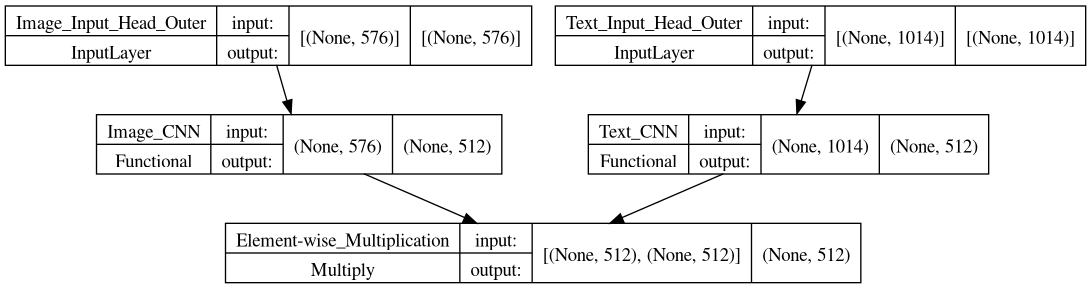

In [31]:
# "Head"

tf.keras.utils.plot_model(mnn_em.model.layers[2], rankdir="TB", show_layer_activations=True, show_shapes=True)

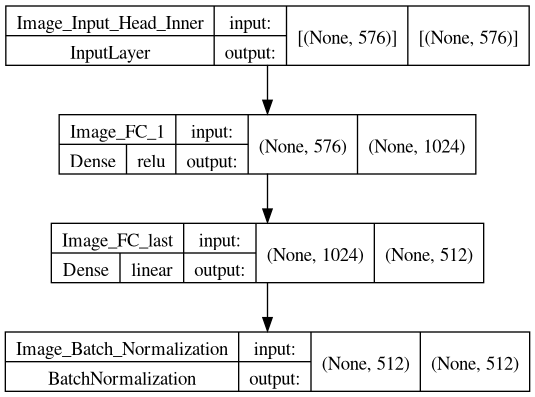

In [32]:
# Image CNN

tf.keras.utils.plot_model(mnn_em.model.layers[2].layers[2], rankdir="TB", show_layer_activations=True, show_shapes=True)

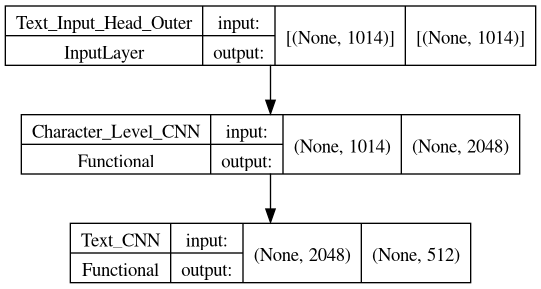

In [33]:
# Text CNN (outer)

tf.keras.utils.plot_model(mnn_em.model.layers[2].layers[3], rankdir="TB", show_layer_activations=True, show_shapes=True)

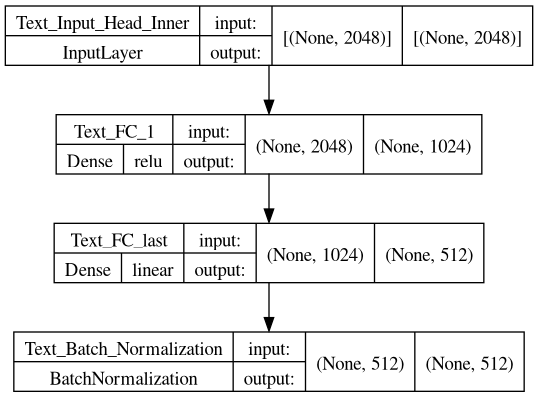

In [36]:
# Text CNN (inner)

tf.keras.utils.plot_model(mnn_em.model.layers[2].layers[3].layers[-1], rankdir="TB", show_layer_activations=True, show_shapes=True)

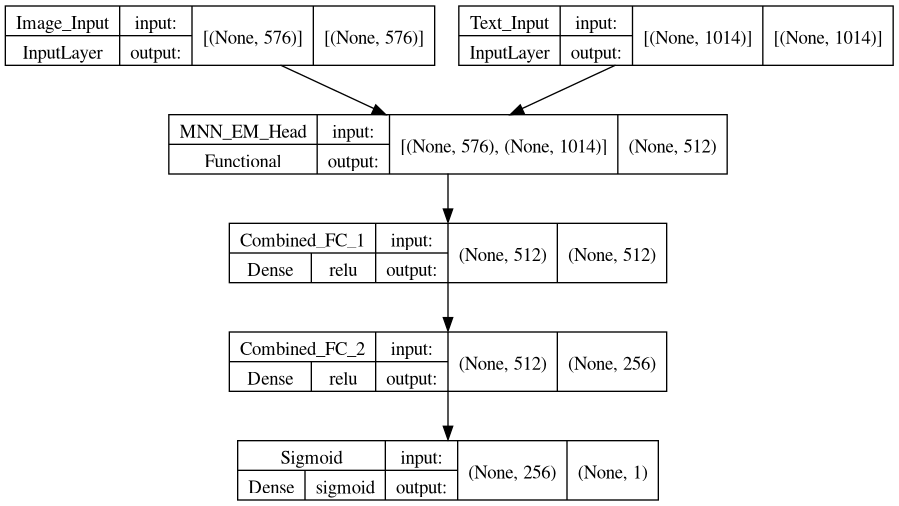

In [35]:
# Full model

tf.keras.utils.plot_model(mnn_em.model, rankdir="TB", show_layer_activations=True, show_shapes=True)

# Callbacks

In [33]:
from utils.eval import create_callbacks

In [34]:
log_dir = config["ext_mnn_em"]["training"]["log_dir"]
model_name = config["ext_mnn_em"]["name"]
optimizer_name = config["ext_mnn_em"]["training"]["optimizer"]
learning_rate = config["ext_mnn_em"]["training"]["learning_rate"]

In [35]:
callbacks = create_callbacks(
    callbacks_list=config["mnn_em"]["training"]["callbacks"],
    log_dir=log_dir,
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"]
    )

# Training

In [ ]:
history = mnn_em.model.fit(
    x=[img_train, text_train],
    y=labels_train,
    epochs=config["mnn_em"]["training"]["epochs"],
    validation_split=config["mnn_em"]["training"]["validation_split"],
    batch_size=config["mnn_em"]["training"]["batch_size"], 
callbacks=callbacks)


# Evaluation

## Plot loss and metrics

In [ ]:
from utils.eval import plot_metrics

In [ ]:
plot_metrics(history.history, config["mnn_em"]["training"]["metrics"], model_name, img_model.name, optimizer_name, learning_rate, config["data"]["cls"])

## Evaluate model and save metrics

In [ ]:
from utils.eval import evaluate

In [ ]:
evaluate(mnn_em.model, [img_test, text_test], labels_test, log_dir, model_name, img_model.name, optimizer_name, learning_rate, config["data"]["cls"])